In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, gen_instance

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T = 5
device = 'cpu'

In [2]:
def train_instance(n, model, optimizer, n_ants):
    model.train()
    demands, distances = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, distances, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(n, model, n_ants):
    model.eval()
    demands, distances = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, distances, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        train_instance(n_node, net, optimizer, n_ants)


@torch.no_grad()
def validation(n_node, n_ants, epoch, net, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    n_val = 100
    for _ in range(n_val):
        bl, sample_best, aco_best = infer_instance(n_node, net, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, -1, net, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    val_best = 1e10
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, epoch, net, animator)
        val_results.append((avg_bl, avg_best, avg_aco_best))
        if avg_aco_best < val_best:
            val_best = avg_aco_best
            torch.save(net.state_dict(), f'../pretrained/cvrp/cvrp{n_node}.pt')
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
    

Learn heuristic for CVRP20: 

total training duration: 116.68992018699646
epoch -1: (11.39045781135559, 9.702742233276368, 9.204134435653687)
epoch 0: (7.14171718120575, 6.04243145942688, 5.4435693359375)
epoch 1: (6.390615344047546, 5.514122610092163, 5.338390657901764)
epoch 2: (5.629793939590454, 4.94996591091156, 4.767108042240142)
epoch 3: (5.581925311088562, 4.965930681228638, 4.790659656524658)
epoch 4: (5.868450698852539, 5.125452489852905, 4.9835599160194395)


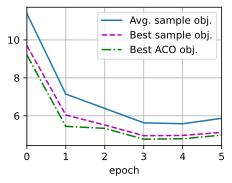

In [5]:
n_node, n_ants = 20, 20
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for CVRP100: 

total training duration: 192.49048495292664
epoch -1: (60.29117279052734, 55.620260620117186, 55.621381301879886)
epoch 0: (22.394395999908447, 20.122700271606444, 18.87579776763916)
epoch 1: (19.255631008148193, 17.406651124954223, 16.49895580291748)
epoch 2: (18.138030529022217, 16.43967698097229, 15.79361249923706)
epoch 3: (18.02038139343262, 16.366943683624267, 15.767643194198609)
epoch 4: (18.454444332122804, 16.762464036941527, 16.190716104507445)


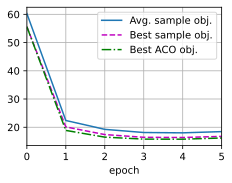

In [6]:
n_node, n_ants = 100, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for CVRP500: 

total training duration: 8334.03388953209
epoch -1: (280.1271969604492, 269.83488891601564, 267.8867178344727)
epoch 0: (97.8207007598877, 94.0157228088379, 92.7621809387207)
epoch 1: (68.17432579040528, 65.7348711013794, 64.67105609893798)
epoch 2: (67.8953214263916, 65.53652961730957, 64.64020839691162)
epoch 3: (65.86680740356445, 62.69952838897705, 61.84901622772217)
epoch 4: (65.32695289611816, 62.85760364532471, 61.88460350036621)


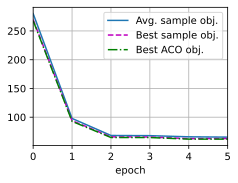

In [7]:
n_node, n_ants = 500, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)